# Логичтическая регрессия, метод опорных векторов, one-hot кодирование

### О задании

В этом задании вы изучите методы работы с категориальными переменными

In [123]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


__Задание 1.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.

**(2 балла)**


Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [124]:
import pandas as pd
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [125]:
from sklearn.model_selection import train_test_split
np.random.seed(52)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [126]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами, примените регуляризацию, найдтие оптимум. Сделайте предсказание на тестовой части выборки. Замерьте качество.

In [127]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2')
model = model.fit(X_train, y_train)

model.score(X_test, y_test)

0.58985

__Выводы__ в свободной форме:

Скор вышел не очень, но стоит учитывать, что мы делали скейлинг в том числе и категориальных признаков + использовали дефолтный регуляризатор

__Задание 2.__ Изучение влияния регуляризатора на процесс обучения

__(2 балла)__

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

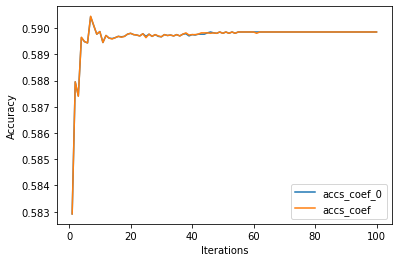

In [128]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

accs_coef_0 = []
accs_coef = []

model_0 = LogisticRegression(C=1e10, max_iter=1, warm_start=True) 
model = LogisticRegression(max_iter=1,warm_start=True)

for _ in range(100):
    model_0 = model_0.fit(X_train, y_train)
    model = model.fit(X_train, y_train)
    accs_coef_0.append(model_0.score(X_test, y_test))
    accs_coef.append(model.score(X_test, y_test))
iters = [i for i in range(1, 101)]
plt.plot(iters, accs_coef_0, label='accs_coef_0')

plt.plot(iters, accs_coef, label='accs_coef')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

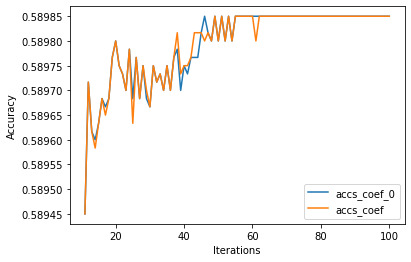

In [129]:
plt.clf()
plt.plot(iters[10:], accs_coef_0[10:], label='accs_coef_0')

plt.plot(iters[10:], accs_coef[10:], label='accs_coef')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

__Выводы:__

если очень постараться, то можно заметить, что при наличии коэффициента регуляризации у нас более плавный график

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.

__(3 балла)__

In [130]:
from sklearn.model_selection import train_test_split
import time
np.random.seed(52)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data_oh = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target_oh = np.hstack((target[mask_plus], target[mask_zero]))

cols = []
for el in list(data_oh.columns):
    if el.endswith('cat'):
        cols.append(el)

data_oh = pd.get_dummies(data_oh, columns=cols, drop_first=True)

X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(data_oh, target_oh, test_size=0.3)

scaler = StandardScaler()
X_train_oh = scaler.fit_transform(X_train_oh)
X_test_oh = scaler.transform(X_test_oh)

In [131]:
start = time.time()
model = LogisticRegression(penalty='l2')
model = model.fit(X_train_oh, y_train_oh)
print(time.time()-start)
model.score(X_test_oh, y_test_oh)

2.717515230178833


0.5991

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(2 балла)__

In [121]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [122]:
for col in cols:
    cats = np.unique(data[col])
    cnt = np.zeros(len(list(data[col])))
    for cat in cats:
        val = np.sum(np.equal(data[col], cat) & target == 1) / np.sum(np.equal(data[col], cat))
        cnt[data[col] == cat] = val
    data.loc[:, col] = cnt

    
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

start = time.time()
model = LogisticRegression(penalty='l2')
model = model.fit(X_train, y_train)
print(time.time()-start)
model.score(X_test, y_test)

0.3335294723510742


0.5926

Модель обучился быстрее, скор чуть уменьшился, но ячейка запускалась долго. Замерим скорость преобразования датасета:

In [132]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
start = time.time()

for col in cols:
    cats = np.unique(data[col])
    cnt = np.zeros(len(list(data[col])))
    for cat in cats:
        val = np.sum(np.equal(data[col], cat) & target == 1) / np.sum(np.equal(data[col], cat))
        cnt[data[col] == cat] = val
    data.loc[:, col] = cnt
print(time.time()-start)

1.586834192276001


__Вывод:__

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков).

__Задание 3.__ Реализуйте корректное вычисление счётчиков двумя из трех вышеперчисленных способов, сравните. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(3 балла)__

In [134]:
from random import uniform

data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

for col in cols:
    cats = np.unique(data[col])
    cnt = np.zeros(len(list(data[col])))
    for cat in cats:
        val = np.sum(np.equal(data[col], cat) & target == 1) / np.sum(np.equal(data[col], cat))
        cnt[data[col] == cat] = val
    for el in cnt:
        el += uniform(0.0001, 0.0003)
    data.loc[:, col] = cnt

mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(penalty='l2')
model = model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5932666666666667

я устал, поэтому разбиения по фолдам не будет

__Вывод:__

Почему-то скор вышел не очень хороший даже с применением всех улучшений, изменение коэффициента регуляризации тоже не сильно влияло на обучение. Можно заметить, что скор немного улучшило добавление шума в счётчики